In [43]:
# Youtube: https://www.youtube.com/watch?v=CogGIdkDA8g

In [581]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from config import *

In [582]:
# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMAGE_DEPTH = 40


IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = DATA_PATH+ '/sliced-output/'
#data_dir = '/home/jain0000/Desktop/data/'
data_dir_train = os.path.join(data_dir, 'train/')
# The images should be stored under: "data/slices/training/img/img"
#data_dir_train_image = os.path.join(data_dir_train, 'image')
data_dir_train_image = os.path.join(data_dir_train, 'image')

# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')
#data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test/')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'image')
#data_dir_test_image = os.path.join(data_dir_test, 'cropped_image')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')
#data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 400
NUM_TEST = 200

NUM_OF_EPOCHS = 100

In [583]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255,
                         rotation_range=10,
                      featurewise_center=True
#                      featurewise_std_normalization=True,
#                      rotation_range=30
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

# Remember not to perform any image augmentation in the test generator!
def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [584]:
train_generator =  (pair for pair in create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN))
test_generator =  (pair for pair in create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST))

Found 1617 images belonging to 1 classes.
Found 1617 images belonging to 1 classes.
Found 662 images belonging to 1 classes.
Found 648 images belonging to 1 classes.


In [585]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [586]:
def show_dataset(datagen, num=2):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

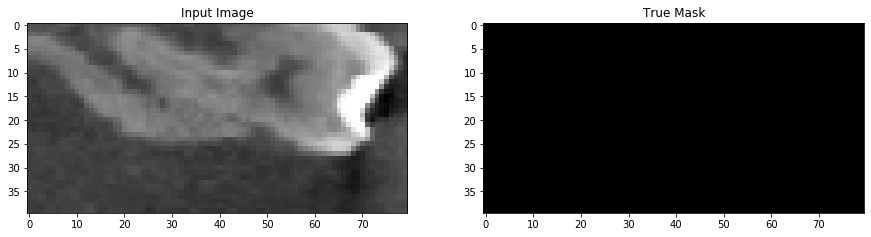

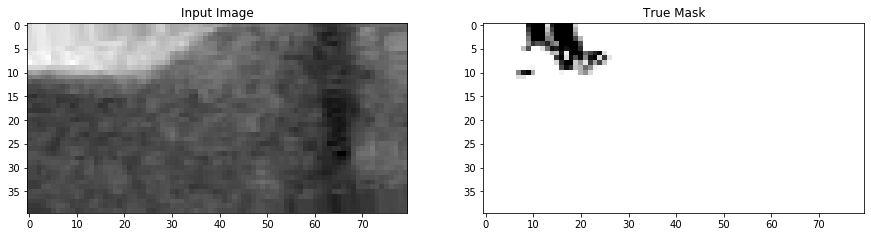

In [587]:
show_dataset(train_generator, 2)

In [588]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
    #    x = keras.layers.BatchNormalization()(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
 #       x = keras.layers.BatchNormalization()(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [589]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=1)])

In [590]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 40, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_800 (Conv2D)             (None, 40, 80, 32)   320         input_60[0][0]                   
__________________________________________________________________________________________________
conv2d_801 (Conv2D)             (None, 40, 80, 32)   9248        conv2d_800[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_156 (MaxPooling2D (None, 20, 40, 32)   0           conv2d_801[0][0]                 
________________________________________________________________________________________

In [591]:


model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=NUM_OF_EPOCHS,callbacks=tensorboard_callback)



Epoch 1/100
12/12 [==============================] - 6s 390ms/step - loss: 0.6631 - mean_io_u_4: 0.4386 - val_loss: 0.4708 - val_mean_io_u_4: 0.4383
Epoch 2/100
12/12 [==============================] - 3s 274ms/step - loss: 0.5903 - mean_io_u_4: 0.4472 - val_loss: 0.4375 - val_mean_io_u_4: 0.4403
Epoch 3/100
12/12 [==============================] - 3s 276ms/step - loss: 0.6195 - mean_io_u_4: 0.4416 - val_loss: 0.4167 - val_mean_io_u_4: 0.4341
Epoch 4/100
12/12 [==============================] - 3s 275ms/step - loss: 0.5706 - mean_io_u_4: 0.4438 - val_loss: 0.4040 - val_mean_io_u_4: 0.4377
Epoch 5/100
12/12 [==============================] - 3s 277ms/step - loss: 0.5570 - mean_io_u_4: 0.4481 - val_loss: 0.3940 - val_mean_io_u_4: 0.4337
Epoch 6/100
12/12 [==============================] - 3s 275ms/step - loss: 0.5642 - mean_io_u_4: 0.4433 - val_loss: 0.4077 - val_mean_io_u_4: 0.4393
Epoch 7/100
12/12 [==============================] - 3s 276ms/step - loss: 0.5404 - mean_io_u_4: 0.4476 - 

Epoch 56/100
12/12 [==============================] - 3s 265ms/step - loss: 0.2852 - mean_io_u_4: 0.4408 - val_loss: 0.6705 - val_mean_io_u_4: 0.4370
Epoch 57/100
12/12 [==============================] - 3s 270ms/step - loss: 0.2649 - mean_io_u_4: 0.4476 - val_loss: 0.6081 - val_mean_io_u_4: 0.4378
Epoch 58/100
12/12 [==============================] - 3s 266ms/step - loss: 0.2548 - mean_io_u_4: 0.4420 - val_loss: 0.6380 - val_mean_io_u_4: 0.4333
Epoch 59/100
12/12 [==============================] - 3s 266ms/step - loss: 0.3068 - mean_io_u_4: 0.4422 - val_loss: 0.5521 - val_mean_io_u_4: 0.4370
Epoch 60/100
12/12 [==============================] - 3s 261ms/step - loss: 0.3508 - mean_io_u_4: 0.4508 - val_loss: 0.7935 - val_mean_io_u_4: 0.4413
Epoch 61/100
12/12 [==============================] - 3s 268ms/step - loss: 0.2551 - mean_io_u_4: 0.4454 - val_loss: 0.7585 - val_mean_io_u_4: 0.4315
Epoch 62/100
12/12 [==============================] - 3s 267ms/step - loss: 0.2173 - mean_io_u_4: 0.

In [592]:
model.save(f'model/UNET-ToothSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5')

In [593]:
test_generator =  (pair for pair in create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1))

Found 662 images belonging to 1 classes.
Found 648 images belonging to 1 classes.


In [594]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

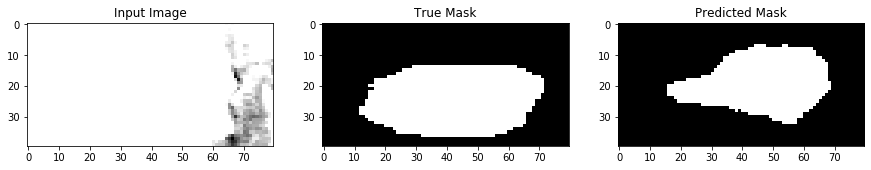

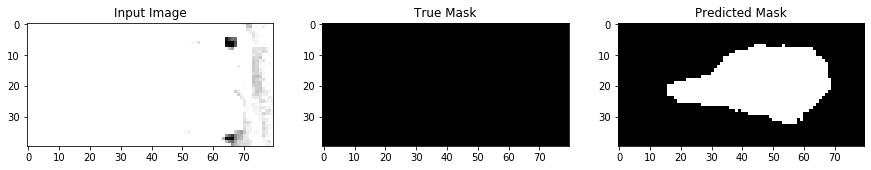

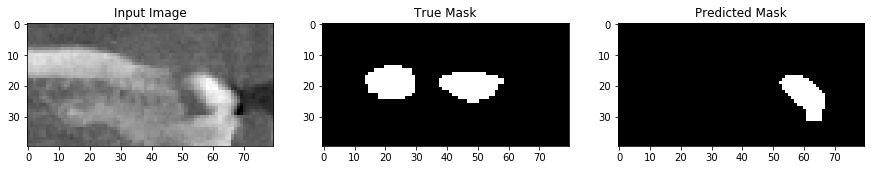

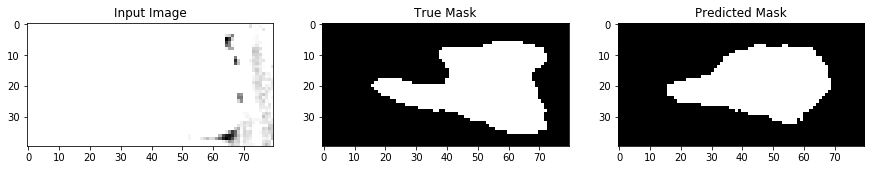

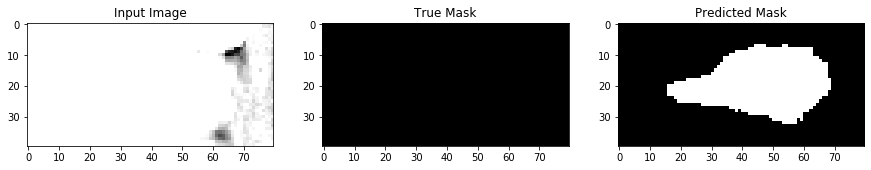

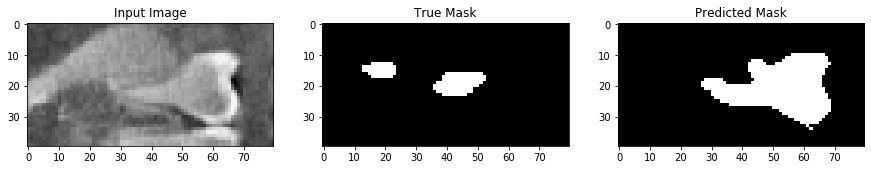

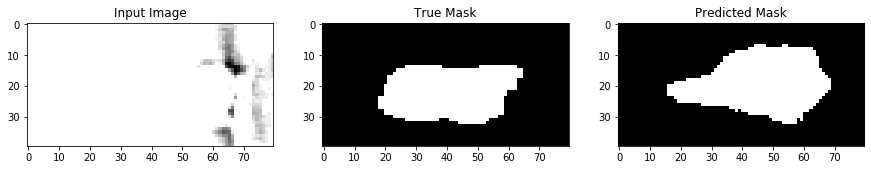

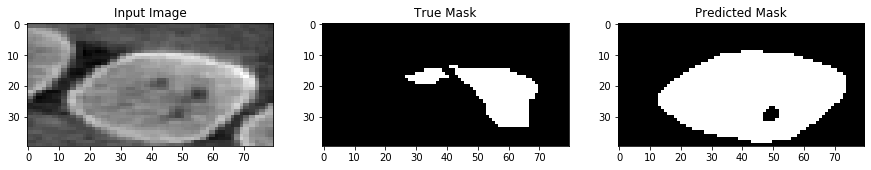

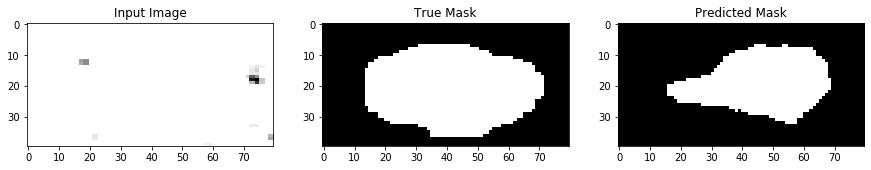

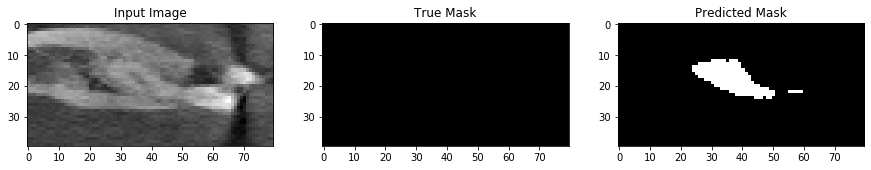

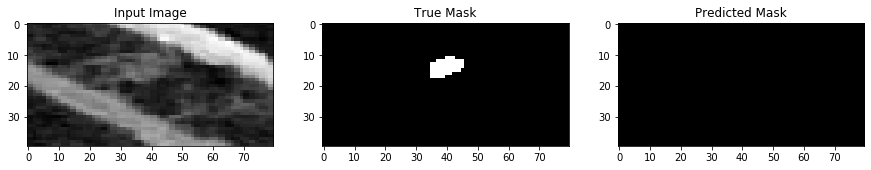

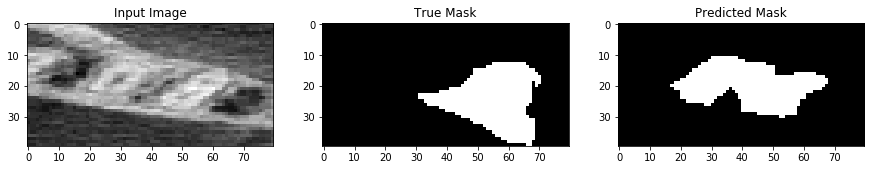

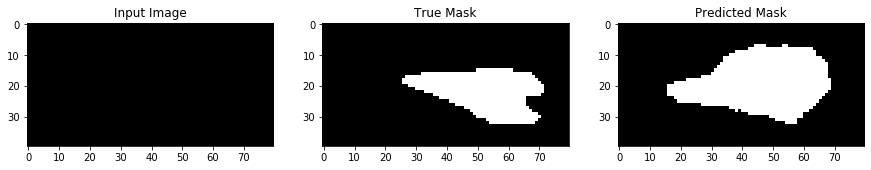

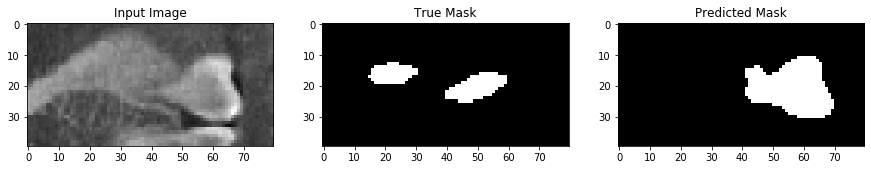

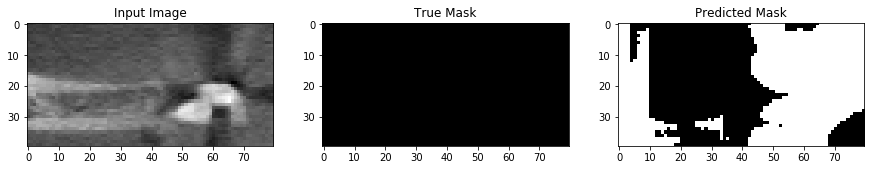

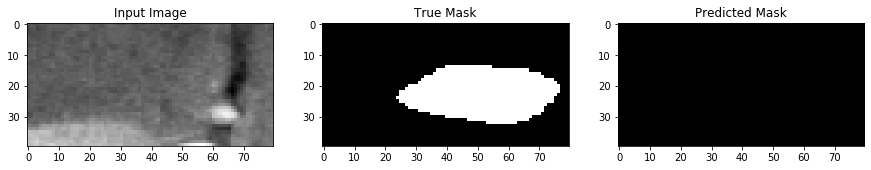

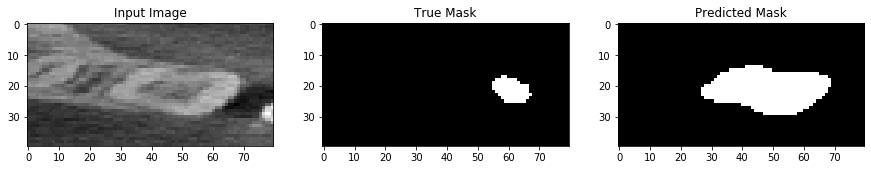

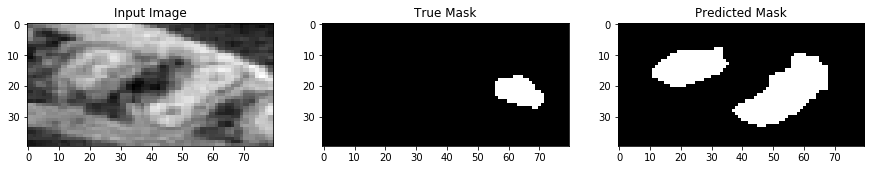

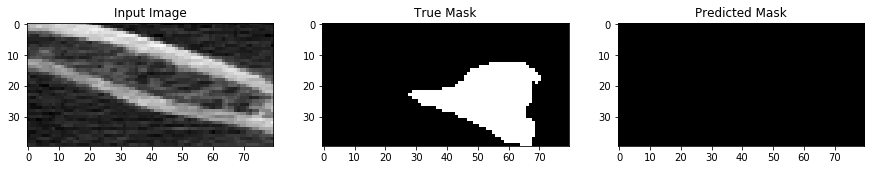

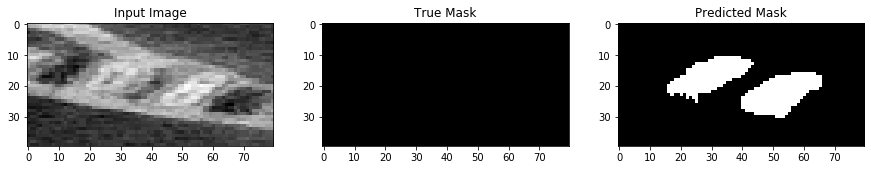

In [595]:
show_prediction(test_generator, 20)

In [450]:
# https://github.com/madsendennis/notebooks